# Optimizing Neural Networks in TensorFlow with Evolution Strategies

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
0 2.302686 2.278973 1.0
100 0.9955279 0.99111235 1.0
200 0.6247898 0.62242204 1.0
300 0.49182308 0.49148893 1.0
400 0.42631036 0.42582905 1.0
500 0.39157665 0.3910508 1.0
600 0.3680781 0.36779183 1.0
700 0.3520685 0.35209608 0.0
800 0.34320933 0.34303987 1.0
900 0.33639312 0.3362795 1.0
1000 0.331126 0.33110413 1.0
1100 0.32698166 0.32700244 0.0
1200 0.32397592 0.32409123 0.0
1300 0.32104203 0.32112488 0.0
1400 0.31878892 0.3186257 1.0
1500 0.3164898 0.31660268 0.0
1600 0.31460384 0.31473115 0.0
1700 0.31235212 0.3124781 0.0
1800 0.31156355 0.3115792 0.0
1900 0.3107081 0.31080484 0.0
0.9121


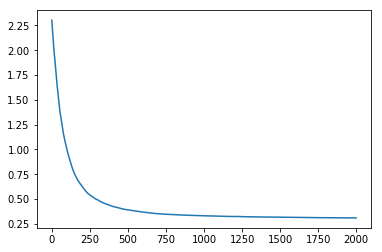

In [8]:
import tensorflow as tf
import numpy as np, matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True)

batch_size = 55000
num_iters = 2000
sigma = 0.01

sigma_ = tf.placeholder(tf.float32, shape=[])
pop_size = 64

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W_var = tf.Variable(tf.zeros([784, 10]))
b_var = tf.Variable(tf.zeros([10]))

def model(x_in, W, b):
    return tf.matmul(x_in, W) + b

def repeat(x, pop_size):
    return tf.tile(tf.expand_dims(x, 0), [pop_size, 1, 1])

def model_2(x_in, W, b):
    matmul = tf.matmul(repeat(x_in, pop_size), W)
    mm = tf.transpose(matmul, [1, 0, 2])
    return mm + b

W_rand = tf.random_normal([pop_size, 784, 10]) * sigma_
b_rand = tf.random_normal([pop_size, 10]) * sigma_

y_var = model(x, W_var, b_var)
y_rand = model_2(x, W_var + W_rand, b_var + b_rand)

y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy_rand = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=tf.tile(tf.expand_dims(y_, 1), [1, pop_size, 1]), logits=y_rand), axis=0)

cross_entropy_var = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_var))

min_cross_entropy = tf.argmin(cross_entropy_rand)

improvement = tf.cast(cross_entropy_rand[min_cross_entropy] < cross_entropy_var, 'float32')

op1 = tf.assign(W_var, W_var + improvement * W_rand[min_cross_entropy])
op2 = tf.assign(b_var, b_var + improvement * b_rand[min_cross_entropy])


sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

loss_history = []
sigma=0.01

for iter in range(num_iters):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    loss, rand_loss, imp, _, _ = sess.run([cross_entropy_var, cross_entropy_rand[min_cross_entropy], improvement, op1, op2], feed_dict={x: batch_xs, y_: batch_ys, sigma_: sigma})
    if iter % 100 == 0:
        print(iter, loss, rand_loss, imp)
    loss_history.append(loss)

correct_prediction = tf.equal(tf.argmax(y_var, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images,
    y_: mnist.test.labels}))

loss_line, = plt.plot(np.array(loss_history), label='loss')
plt.show()

# References

https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/examples/tutorials/mnist/mnist_softmax.py